# Rapidly-Exploring Random Tree (RRT)

Your task is to generate an RRT based on the following pseudocode:

```
def generate_RRT(x_init, num_vertices, dt):
    rrt = RRT(x_init)
    for k in range(num_vertices):
        x_rand = sample_state()
        x_near = nearest_neighbor(x_rand, rrt)
        u = select_input(x_rand, x_near)
        x_new = new_state(x_near, u, dt)
        # directed edge
        rrt.add_edge(x_near, x_new, u)
    return rrt
```
    
The `RRT` class has already been implemented. Your task is to complete the implementation of the following functions:

* `sample_state`
* `nearest_neighbor`
* `select_input`
* `new_state`


In [129]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
import networkx as nx

In [130]:
plt.rcParams['figure.figsize'] = 12, 12

In [131]:
class RRT:
    def __init__(self, x_init):
        # A tree is a special case of a graph with
        # directed edges and only one path to any vertex.
        self.tree = nx.DiGraph()
        self.tree.add_node(x_init)
                
    def add_vertex(self, x_new):
        self.tree.add_node(tuple(x_init))
    
    def add_edge(self, x_near, x_new, u):
        self.tree.add_edge(tuple(x_near), tuple(x_new), orientation=u)
    
    def add_edges_from(self, line, u):
        self.tree.add_edges_from(line, orientation = u)
        
    @property
    def vertices(self):
        return self.tree.nodes()
    
    @property
    def edges(self):
        return self.tree.edges()
                                                  

In [132]:
def create_grid():
    grid = np.zeros((100, 100))
    # build some obstacles
    grid[10:20, 10:20] = 1
    grid[63:80, 10:20] = 1
    grid[43:60, 30:40] = 1
    grid[71:86, 38:50] = 1
    grid[10:20, 55:67] = 1
    grid[80:90, 80:90] = 1
    grid[75:90, 80:90] = 1
    grid[30:40, 60:82] = 1
    return grid

def create_rand_grid(num_obst, x = 100, y = 100):
    """
    Random obstacles
    Input: x_size - optional, def = 100
           y_size - optional, dif = 100
           num_of_obst
    """
    grid = np.zeros((x,y))
    x_c = np.random.randint(1, x, num_obst)
    y_c = np.random.randint(1, x, num_obst)
    dx = np.random.randint(x//(3*num_obst),x//(num_obst), num_obst)
    dy = np.random.randint(y//(3*num_obst),y//(num_obst), num_obst)
    centers = list(zip(*[x_c, y_c]))
    for ind in range(num_obst):
        obstacle = [
            int(np.clip((x_c[ind] - dx[ind]), 0, x - 1)),
            int(np.clip((x_c[ind] + dx[ind]), 0, x - 1)),
            int(np.clip((y_c[ind] - dy[ind]), 0, y - 1)),
            int(np.clip((y_c[ind] + dy[ind]), 0, y - 1))
        ]
        grid[obstacle[0]:obstacle[1], obstacle[2]:obstacle[3]] = 1
        
    return grid

In [133]:
# environment encoded as a grid
grid = create_rand_grid(8)

Let's take a look at the example environment we'll be using.

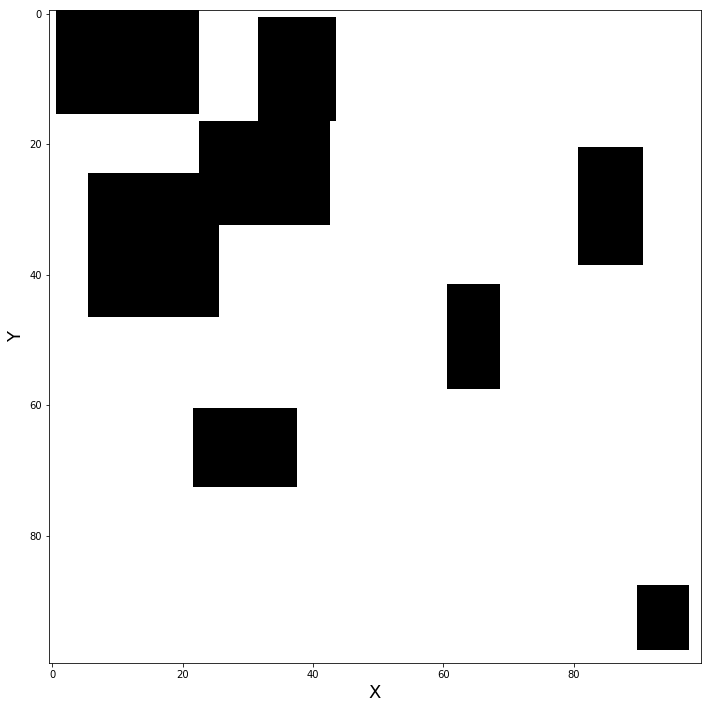

In [134]:
plt.imshow(grid, cmap='Greys', origin='upper')
plt.xlabel('X', fontsize = 18)
plt.ylabel('Y', fontsize = 18)
plt.show()

Next you'll implement the functions necessary to generate an RRT. Feel free to change the function signatures however you please, just remember to update `generate_RRT` accordingly.

### Sampling States

The first part of generating an RRT is sampling states based on the environment. The sampled state must be in free space. 

In [135]:
def sample_state(grid):
    x = np.random.uniform(0,grid.shape[0]) 
    y = np.random.uniform(0,grid.shape[1])
    #while grid[int(x), int(y)] ==1:
        #sample_state(grid)
    #print(x,y,int(x),int(y) ,grid[int(x),int(y)])
    return (x, y)

### Nearest Neighbors

A critical part of the RRT procedure is finding the closest vertex to the sampled random point. This the most computationally intensive part so be mindful of that. Depending on the number of vertices a naive implementation will run into trouble quickly.

In [136]:
def nearest_neighbor(x_rand, rrt):
    #print(rrt.vertices, 'ku',list(rrt.vertices))
    tree = KDTree(list(rrt.vertices),leaf_size = 40)
    #print(np.asarray(x_rand).reshape(1,-1), x_rand)
    dist,ind = tree.query(np.asarray(x_rand).reshape(1,-1), k=1)
    #print(dist, ind,type(ind[0][0]))
    return list(rrt.vertices)[ind[0][0]]

### Selecting Inputs

Select input which moves `x_near` closer to `x_rand`. This should return the angle or orientation of the vehicle.

In [137]:
def select_input(x_rand, x_near):
    return np.arctan2(x_rand[1] - x_near[1], x_rand[0] - x_near[0])

### New State



The new vertex `x_new` is calculated by travelling from the current vertex `x_near` with a orientation `u` for time `dt`.

In [155]:
def new_state(x_near, u, dt):
    line = [x_near]
    #boom = 0
    T = dt
    if dt > 0.5:
        dt = np.clip(T/10, 0.01, 0.1)
    for _ in np.arange(0, T, dt):
        state = simulate(line[-1], u, dt)
        if grid[int(state[0]), int(state[1])] == 1:
            #print('boom')
            break
        else:
            line.append(state)
    #print("dt", dt,'grid', grid.shape)
    return line
    
def simulate(state_init, angle, dt):
    x = state_init[0]
    y = state_init[1]
    #print('x',x,'y',y)
    nx = np.clip(x + np.cos(angle)*dt, 0, grid.shape[0] - 1)
    ny = np.clip(y + np.sin(angle)*dt, 0, grid.shape[1] - 1)    
    
    return [nx, ny]

### Putting It All Together

Awesome! Now we'll put everything together and generate an RRT.

In [146]:
def generate_RRT(grid, x_init, num_vertices, dt):
    
    rrt = RRT(x_init)
    #boom = 0
    
    for _ in range(num_vertices):
        
        x_rand = sample_state(grid)
        #print(x_rand)
        # sample states until a free state is found
        while grid[int(x_rand[0]), int(x_rand[1])] == 1:
            x_rand = sample_state(grid)
            
        x_near = nearest_neighbor(x_rand, rrt)
        u = select_input(x_rand, x_near)
        line_new = new_state(x_near, u, dt)
            
        #if grid[int(x_new[0]), int(x_new[1])] == 0:
            # the orientation `u` will be added as metadata to
            # the edge
        #print('linenew', line_new[-1])
        rrt.add_edge(x_near,line_new[-1], u)
        #else:
            #boom += 1
    #print("BOOM!", boom)
            
    return rrt

Feel free to change any of the values below.

In [158]:
num_vertices = 5000
dt = 1
#x_init = (50, 50)
x_init = sample_state(grid)
while grid[int(x_init[0]), int(x_init[1])] == 1:
    x_init = sample_state(grid)
    
rrt = generate_RRT(grid, x_init, num_vertices, dt)

Now let's plot the generated RRT.

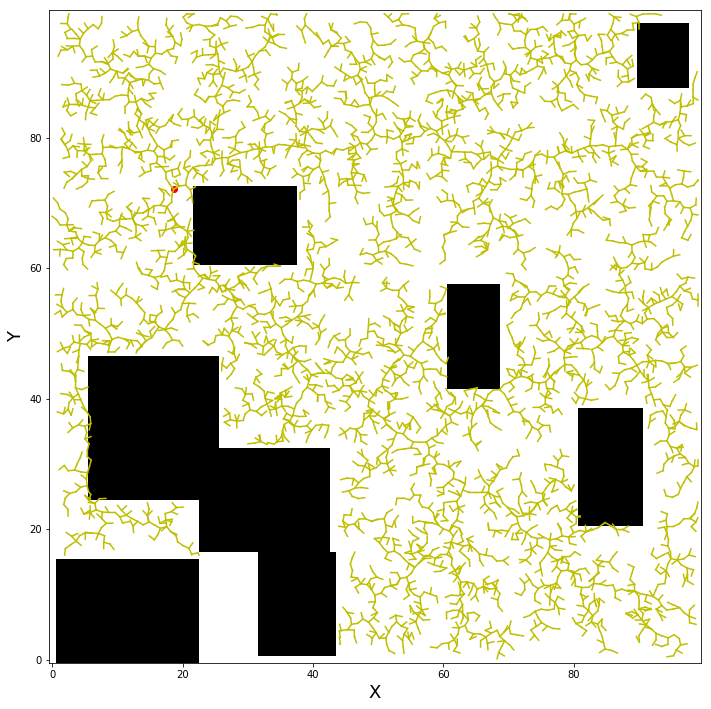

In [159]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.plot(x_init[1], x_init[0], 'ro')
plt.xlabel("X", fontsize = 18)
plt.ylabel("Y", fontsize = 18)

for (v1, v2) in rrt.edges:
    plt.plot([v1[1], v2[1]], [v1[0], v2[0]], 'y-')

plt.show()

[solution](/notebooks/RRT-Solution.ipynb)